--- 1. Création du Schéma (RDFS/OWL) ---
--- 2. Ajout des Données (Triplets) ---

--- 3. Exécution des Requêtes SPARQL ---

Q1: Combien d'iPhone15 dans StoreA ?
-> Résultat : <built-in method count of ResultRow object at 0x000001F4250B9540>

Q2: Produits achetés avec iPhone15 dans StoreA ?
-> Résultat : AirPods

Q3: Catalogue des produits vendus par StoreA ?
-> Résultat : iPhone15
-> Résultat : AirPods

--- 4. Génération de la Visualisation ---


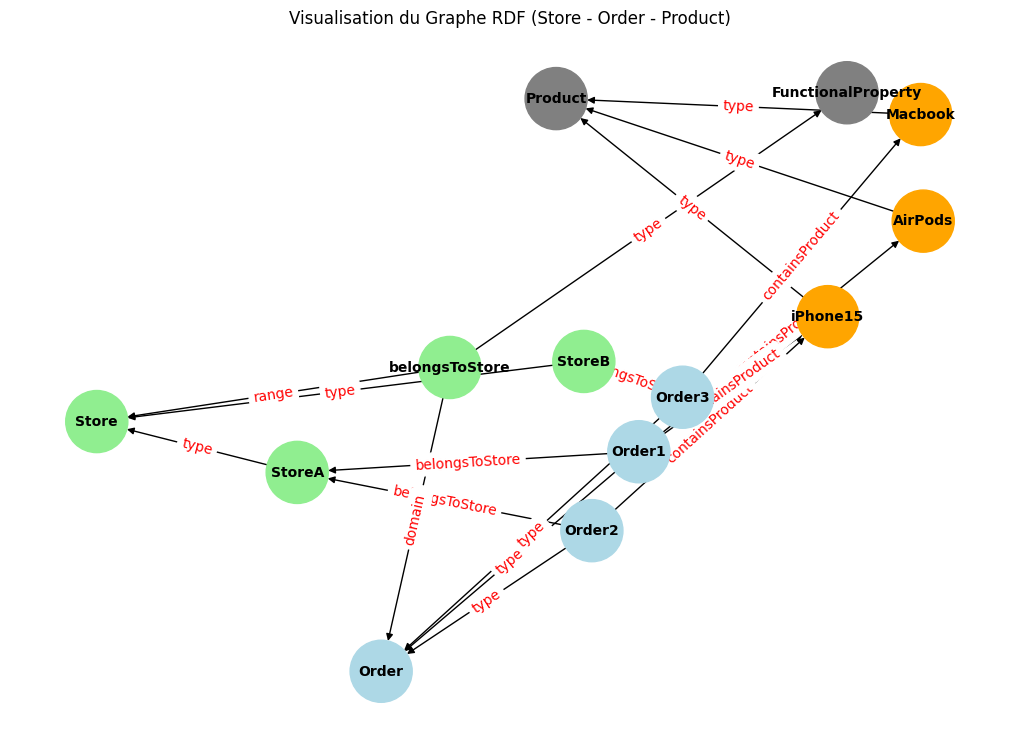

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from rdflib import Graph, Namespace, RDF, RDFS, OWL, Literal

# ==========================================
# 1. INITIALISATION DU GRAPHE ET NAMESPACES
# ==========================================
g = Graph()
EX = Namespace("http://example.org/retail#")
g.bind("ex", EX) # Pour raccourcir les URIs dans l'affichage

# ==========================================
# 2. MODÉLISATION (RDFS + OWL)
# ==========================================
print("--- 1. Création du Schéma (RDFS/OWL) ---")

# Définition des Classes
g.add((EX.Store, RDF.type, RDFS.Class))
g.add((EX.Order, RDF.type, RDFS.Class))
g.add((EX.Product, RDF.type, RDFS.Class))

# Définition des Propriétés
g.add((EX.containsProduct, RDF.type, RDF.Property))
g.add((EX.containsProduct, RDFS.domain, EX.Order))
g.add((EX.containsProduct, RDFS.range, EX.Product))

# OWL: Une commande appartient à un SEUL magasin (FunctionalProperty)
g.add((EX.belongsToStore, RDF.type, OWL.FunctionalProperty))
g.add((EX.belongsToStore, RDFS.domain, EX.Order))
g.add((EX.belongsToStore, RDFS.range, EX.Store))

# ==========================================
# 3. CRÉATION DES DONNÉES (RDF)
# ==========================================
print("--- 2. Ajout des Données (Triplets) ---")

# Instanciation des Magasins et Produits
g.add((EX.StoreA, RDF.type, EX.Store))
g.add((EX.StoreB, RDF.type, EX.Store))
g.add((EX.iPhone15, RDF.type, EX.Product))
g.add((EX.AirPods, RDF.type, EX.Product))
g.add((EX.Macbook, RDF.type, EX.Product))

# Commande 1 (StoreA: iPhone + AirPods)
g.add((EX.Order1, RDF.type, EX.Order))
g.add((EX.Order1, EX.belongsToStore, EX.StoreA))
g.add((EX.Order1, EX.containsProduct, EX.iPhone15))
g.add((EX.Order1, EX.containsProduct, EX.AirPods))

# Commande 2 (StoreA: iPhone seul)
g.add((EX.Order2, RDF.type, EX.Order))
g.add((EX.Order2, EX.belongsToStore, EX.StoreA))
g.add((EX.Order2, EX.containsProduct, EX.iPhone15))

# Commande 3 (StoreB: Macbook)
g.add((EX.Order3, RDF.type, EX.Order))
g.add((EX.Order3, EX.belongsToStore, EX.StoreB))
g.add((EX.Order3, EX.containsProduct, EX.Macbook))

# ==========================================
# 4. REQUÊTES SPARQL
# ==========================================
print("\n--- 3. Exécution des Requêtes SPARQL ---")

# Q1: Combien d'iPhone15 vendus dans StoreA ?
q1 = """
    SELECT (COUNT(?order) AS ?count)
    WHERE {
        ?order ex:belongsToStore ex:StoreA .
        ?order ex:containsProduct ex:iPhone15 .
    }
"""
print("\nQ1: Combien d'iPhone15 dans StoreA ?")
for row in g.query(q1):
    print(f"-> Résultat : {row.count}")

# Q2: Produits achetés avec iPhone15 dans StoreA ?
q2 = """
    SELECT ?otherProduct
    WHERE {
        ?order ex:belongsToStore ex:StoreA .
        ?order ex:containsProduct ex:iPhone15 .
        ?order ex:containsProduct ?otherProduct .
        FILTER (?otherProduct != ex:iPhone15)
    }
"""
print("\nQ2: Produits achetés avec iPhone15 dans StoreA ?")
for row in g.query(q2):
    # On nettoie l'URI pour l'affichage
    product_name = row.otherProduct.split("#")[-1]
    print(f"-> Résultat : {product_name}")

# Q3: Quels produits sont vendus par StoreA ?
q3 = """
    SELECT DISTINCT ?product
    WHERE {
        ?order ex:belongsToStore ex:StoreA .
        ?order ex:containsProduct ?product .
    }
"""
print("\nQ3: Catalogue des produits vendus par StoreA ?")
for row in g.query(q3):
    product_name = row.product.split("#")[-1]
    print(f"-> Résultat : {product_name}")

# ==========================================
# 5. VISUALISATION DU GRAPHE
# ==========================================
print("\n--- 4. Génération de la Visualisation ---")

def visualize_graph(g):
    nx_graph = nx.DiGraph()
    
    # Mapping des couleurs pour les types de nœuds
    color_map = []
    labels = {}
    
    for s, p, o in g:
        # On ignore les définitions de schéma (Classes/Propriétés) pour alléger le dessin
        # On ne garde que les instances (Store, Order, Product)
        if (s, RDF.type, RDFS.Class) not in g and (s, RDF.type, RDF.Property) not in g:
             if isinstance(s, type(EX.Term)) and isinstance(o, type(EX.Term)):
                # Nettoyage des noms pour l'affichage
                s_label = s.split("#")[-1]
                o_label = o.split("#")[-1]
                p_label = p.split("#")[-1]
                
                # Ajout des arêtes
                nx_graph.add_edge(s_label, o_label, label=p_label)
    
    # Définition des couleurs des nœuds
    for node in nx_graph:
        if "Store" in node: color_map.append('lightgreen')
        elif "Order" in node: color_map.append('lightblue')
        elif "iPhone" in node or "AirPods" in node or "Macbook" in node: color_map.append('orange')
        else: color_map.append('grey')

    pos = nx.spring_layout(nx_graph, k=0.8) # Positionnement
    plt.figure(figsize=(10, 7))
    
    # Dessin des nœuds
    nx.draw(nx_graph, pos, with_labels=True, node_color=color_map, 
            node_size=2000, font_size=10, font_weight="bold", arrows=True)
    
    # Dessin des labels des arêtes
    edge_labels = nx.get_edge_attributes(nx_graph, 'label')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Visualisation du Graphe RDF (Store - Order - Product)")
    plt.show()

# Lancer la visualisation
visualize_graph(g)

In [3]:
import re
import rdflib
import spacy
import inflect
from pathlib import Path
from rdflib import Namespace, Literal
from rdflib.namespace import RDF, RDFS, OWL

# ===================================================
#                 CONFIGURATION
# ===================================================

# Si vous voulez tester avec un fichier, mettez le chemin ici (ex: Path("mon_texte.txt"))
# Sinon, laissez None pour utiliser le texte par défaut.
INPUT_FILE = None 
OUTPUT_FILE = "ontology.ttl"

# Le texte à analyser (Exemple adapté à votre besoin initial)
DEFAULT_TEXT = """
StoreA possède plusieurs magasins.
Chaque magasin enregistre des commandes.
Une commande contient des produits comme IPhone, AirPods, Macbook.
IPhone est un produit.
"""

# ===================================================
#           UTILITAIRES LINGUISTIQUES
# ===================================================

inf = inflect.engine()

def clean_text(s: str):
    """Retire la ponctuation et met en minuscules."""
    s = s.lower()
    # On garde les accents français
    s = re.sub(r"[^a-z0-9àâäéèêëîïôöùûüç' ]+", "", s)
    return s.strip()

def remove_determinants(s: str):
    """Supprime les déterminants courants."""
    det = [
        "les ", "des ", "du ", "de la ", "de l'", "un ", "une ",
        "le ", "la ", "l'", "plusieurs ", "certains ", "chaque "
    ]
    for d in det:
        if s.startswith(d):
            s = s[len(d):]
    return s

def singularize(text: str):
    """Tente de mettre les mots au singulier."""
    words = text.split()
    sg = []
    for w in words:
        # inflect est optimisé pour l'anglais, attention aux faux positifs en FR
        cand = inf.singular_noun(w)
        sg.append(cand if cand else w)
    return " ".join(sg)

def normalize_concept(text: str):
    """Pipeline complet de nettoyage."""
    text = clean_text(text)
    text = remove_determinants(text)
    text = singularize(text)
    text = text.strip()
    text = re.sub(r"\s+", "_", text)  # Remplacement espaces par underscore
    return text

def is_generic(word: str):
    """Filtre les mots trop génériques."""
    blacklist = {"chose", "élément", "truc", "personne", "objet", "quelque", "cela"}
    return word in blacklist

# ===================================================
#                 NLP CHARGEMENT
# ===================================================

def load_nlp():
    """Charge un modèle spaCy (français préféré)."""
    try:
        print("Chargement du modèle 'fr_core_news_md'...")
        return spacy.load("fr_core_news_md")
    except OSError:
        try:
            print("Modèle 'md' non trouvé, essai avec 'fr_core_news_sm'...")
            return spacy.load("fr_core_news_sm")
        except OSError:
            print("ERREUR: Aucun modèle français trouvé.")
            print("Veuillez exécuter dans le terminal: python -m spacy download fr_core_news_sm")
            raise

# ===================================================
#              EXTRACTION DES DONNÉES
# ===================================================

def extract_concepts(doc):
    classes = set()
    individuals = set()

    for token in doc:
        # Noms communs -> Classes potentielles
        if token.pos_ == "NOUN":
            c = normalize_concept(token.text)
            if len(c) > 2 and not is_generic(c):
                classes.add(c)

        # Noms propres -> Individus potentiels
        elif token.pos_ == "PROPN":
            i = normalize_concept(token.text)
            if len(i) > 2:
                individuals.add(i)

    # Noun chunks pour attraper les concepts composés
    for chunk in doc.noun_chunks:
        c = normalize_concept(chunk.text)
        if len(c) > 2 and not is_generic(c):
            classes.add(c)

    return classes, individuals

def extract_relations(doc):
    relations = []

    for token in doc:
        if token.pos_ != "VERB":
            continue

        verb = normalize_concept(token.lemma_)

        # Récupération des dépendances syntaxiques
        subjects = [c for c in token.children if "subj" in c.dep_]
        objects = [c for c in token.children if "obj" in c.dep_] # obj direct, pobj, etc.
        
        # Pour simplifier, on prend aussi les obl (obliques) comme objets cibles
        others = [c for c in token.children if c.dep_ in {"obl", "iobj"}]
        targets = objects + others

        if subjects and targets:
            for s in subjects:
                for o in targets:
                    relations.append((
                        normalize_concept(s.text), 
                        verb, 
                        normalize_concept(o.text)
                    ))
    return relations

# ===================================================
#            CONSTRUCTION ONTOLOGIE (RDF)
# ===================================================

def build_ontology(classes, individuals, relations, output_file):
    g = rdflib.Graph()
    EX = Namespace("http://example.org/onto#")
    g.bind("ex", EX)

    # Création des Classes
    for c in classes:
        uri = EX[c]
        g.add((uri, RDF.type, OWL.Class))
        g.add((uri, RDFS.label, Literal(c.replace("_", " "), lang="fr")))

    # Création des Individus
    for i in individuals:
        uri = EX[i]
        g.add((uri, RDF.type, OWL.NamedIndividual))
        g.add((uri, RDFS.label, Literal(i.replace("_", " "), lang="fr")))

    # Création des Propriétés et Relations
    for s, v, o in relations:
        prop = EX[v]
        # On définit le verbe comme une ObjectProperty
        g.add((prop, RDF.type, OWL.ObjectProperty))
        g.add((prop, RDFS.label, Literal(v.replace("_", " "), lang="fr")))

        # Ajout du triplet (Sujet, Predicat, Objet) si ce sont des individus ou classes connues
        # Note : Dans une vraie ontologie, on ferait la distinction Classe vs Instance ici.
        # Pour cet exemple simple, on utilise les URI générées.
        g.add((EX[s], prop, EX[o]))

    # Sauvegarde
    g.serialize(output_file, format="turtle")
    print(f"\n🟩 Ontologie générée avec succès : {output_file}")
    
    # Affichage rapide du résultat
    print("-" * 40)
    print(g.serialize(format="turtle"))

# ===================================================
#                       MAIN
# ===================================================

def main():
    # 1. Chargement NLP
    nlp = load_nlp()

    # 2. Gestion entrée texte
    if INPUT_FILE and INPUT_FILE.exists():
        text = INPUT_FILE.read_text(encoding="utf-8")
    else:
        text = DEFAULT_TEXT

    print(f"Analyse du texte : \n{text.strip()}\n")
    
    # 3. Traitement
    doc = nlp(text)
    classes, individuals = extract_concepts(doc)
    relations = extract_relations(doc)

    # 4. Affichage console
    print("\n🟦 Classes détectées :")
    for c in sorted(classes):
        print("  -", c)

    print("\n🟦 Individus détectés :")
    for i in sorted(individuals):
        print("  -", i)

    print("\n🟦 Relations détectées :")
    for s, v, o in relations:
        print(f"  - {s} --[{v}]--> {o}")

    # 5. Génération RDF
    build_ontology(classes, individuals, relations, OUTPUT_FILE)

if __name__ == "__main__":
    main()

Chargement du modèle 'fr_core_news_md'...
Modèle 'md' non trouvé, essai avec 'fr_core_news_sm'...
Analyse du texte : 
StoreA possède plusieurs magasins.
Chaque magasin enregistre des commandes.
Une commande contient des produits comme IPhone, AirPods, Macbook.
IPhone est un produit.


🟦 Classes détectées :
  - commande
  - enregistre
  - iphone
  - magasin
  - produit
  - storea

🟦 Individus détectés :
  - iphone
  - macbook

🟦 Relations détectées :
  - commande --[contenir]--> produit
  - commande --[contenir]--> produit

🟩 Ontologie générée avec succès : ontology.ttl
----------------------------------------
@prefix ex: <http://example.org/onto#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:commande a owl:Class ;
    rdfs:label "commande"@fr ;
    ex:contenir ex:produit .

ex:contenir a owl:ObjectProperty ;
    rdfs:label "contenir"@fr .

ex:enregistre a owl:Class ;
    rdfs:label "enregistre"@fr .

ex:iphone a owl:Class